In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lish-moa/train_targets_scored.csv
/kaggle/input/lish-moa/sample_submission.csv
/kaggle/input/lish-moa/train_drug.csv
/kaggle/input/lish-moa/train_targets_nonscored.csv
/kaggle/input/lish-moa/train_features.csv
/kaggle/input/lish-moa/test_features.csv


# **Mechanism of Action Prediction**
Beta blockers exert their pharmacological effect, decreased heart rate, by binding to receptor.
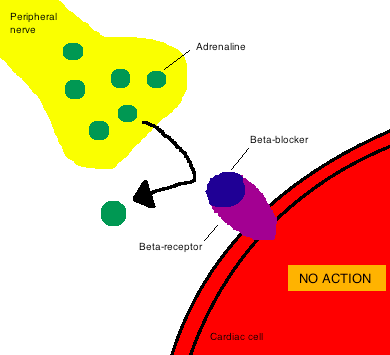
#### What is Mechanim of Action?
The term mechanism of action means the biochemical interactions through which a drug generates its pharmacological effect.A mechanism of action includes specific molecular targets to which the drug binds, such as an enzyme or receptor.
#### Why to predict Mechanism of Action ?
If we know a disease affects some particular receptor or downstream set of cell activity, we can develop drugs faster if we can predict how cells and genes affect various receptor sites.
# **Problem Discription**
For this competition,we will have dataset that combines gene expression and cell viability data in addition to the MoA annotations of more than 5,000 drugs.
In this competition, each drug was tested under two dose (cp_dose) and three times (cp_time). So, six samples basically correspond to one drug.
We are going to train a model that classifies drugs based on their biological activity.
This problem is a multilabel classification, which means we have multiple targets (not multiple classes).
In this project, we will first perform explanatory data analysis and then train a model using deep neural networks with Keras. We will do a bit model evaluation at the end.

# **Dataset information**

1. **x_train.csv** - Features for the training set. Features g- signify gene expression data, and c- signify cell viability data. cp_type indicates samples treated with a compound (cp_vehicle) or with a control perturbation (ctrl_vehicle); control perturbations have no MoAs; cp_time and cp_dose indicate treatment duration (24, 48, 72 hours) and dose (high or low).

2. **train_targets_scored.csv** - The binary MoA targets that are scored.



3. **test_features.csv** - Features for the test data. You must predict the probability of each scored MoA for each row in the test data.

4. **sample_submission.csv** - A submission file in the correct format.

5. **Train drug** - Contains the name of the drug id corresponding to sig_no

# Importing Libraries and dataset 

In [1]:
# Importing useful libraries
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
from random import sample 


In [2]:
# import data into dataframe
x_train= pd.read_csv('C:/Users/J P PANDEY/Desktop/MOA/train_features.csv')
x_test = pd.read_csv("C:/Users/J P PANDEY/Desktop/MOA/test_features.csv")
y_train= pd.read_csv("C:/Users/J P PANDEY/Desktop/MOA/train_targets_scored.csv")
drug=pd.read_csv('C:/Users/J P PANDEY/Desktop/MOA/train_drug.csv')

In [4]:
# get number of rows and columns
x_train.shape,x_test.shape

((23814, 876), (3982, 876))

In [9]:
# to print the dtype of column
x_train.dtypes

sig_id      object
cp_type     object
cp_time      int64
cp_dose     object
g-0        float64
            ...   
c-95       float64
c-96       float64
c-97       float64
c-98       float64
c-99       float64
Length: 876, dtype: object

# **Feature Discription,Stats and there distribution so to understand the data**

In [5]:
print("Training missing data:", x_train.isnull().sum().sum())
print("Testing missing data:", x_train.isnull().sum().sum())
print("Target missing data:",x_train.isnull().sum().sum())

Training missing data: 0
Testing missing data: 0
Target missing data: 0


There is no missing values in this dataset

In [10]:
print("Train-data")
print(x_train.select_dtypes('float64').agg(['var','std','kurt','skew']).transpose())
print("---------------------------------------------------------")
print("Test-data")
print(x_test.select_dtypes('float64').agg(['var','std','kurt','skew']).transpose())

Train-data
           var       std       kurt      skew
g-0   1.941560  1.393399  11.332955  2.790270
g-1   0.659934  0.812363   2.305161 -0.169398
g-2   1.072739  1.035731   3.893016  0.361242
g-3   0.902523  0.950012  10.988063  1.816132
g-4   1.065212  1.032091   6.895809  1.092531
...        ...       ...        ...       ...
c-95  2.654588  1.629291  14.322822 -3.423862
c-96  4.242467  2.059725  11.498551 -3.289216
c-97  2.902304  1.703615  12.822259 -3.310345
c-98  3.366593  1.834828  10.141278 -2.981826
c-99  1.982232  1.407918  12.239080 -3.057907

[872 rows x 4 columns]
---------------------------------------------------------
Test-data
           var       std       kurt      skew
g-0   1.886436  1.373476  12.264263  2.946877
g-1   0.640917  0.800573   2.123702  0.091822
g-2   1.137368  1.066475   5.035973  0.193435
g-3   0.902446  0.949972  13.186187  2.259925
g-4   0.988072  0.994018   7.135725  1.051108
...        ...       ...        ...       ...
c-95  2.708227  1.64566

In [ ]:
train_genes = [s for s in x_train.columns if "g-" in s]
train_cellvia = [s for s in x_train.columns if "c-" in s]
print(str(len(train_genes))+"  gene features")
print(str(len(train_cellvia))+"   cell viabilty features")

1.   There are 772 gene expression features, each denoted by "g-". Each gene feature represents the expression of one particular gene. Therefor, there are 772 individual genes being monitored in the dataset.
2.   There are 100 cell viability features, each denoted by "c-". Each cell feature represents the viability of one particular cell line. Therefor, there are 100 individual cell lines being monitored in the dataset.

In [11]:
def color_negative_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'red' if val < 0 else 'black'
    return 'color: %s' % color


In [12]:
s = x_train.iloc[:10,4:].style.applymap(color_negative_red)
s

- Regulation of gene expression : Includes a wide range of mechanisms that are used by cells to increase or decrease the production of specific gene products 
   So there are two regulation :
   Downregulation is the process by which a cell decreases the quantity of a cellular component, such as RNA or protein, in response to an external stimulus. The complementary process that involves increases of such components is called upregulation.

- In cell vability negitive value means cells is decreasing in number and positive value means cells are increasing after taking that drugs

In [13]:
c=x_train.describe()
c=c.reset_index()
def highlight_greaterthan(x):
    if x['index'] == 'min':
      return ['background-color: yellow']*874
    elif x['index'] == 'max':
      return ['background-color: yellow']*874
    else:
        return ['background-color: white']*874
c.style.apply(highlight_greaterthan, axis=1)

- From this table we can see that our values are normalized between -10 to 10
- So, now we are making a plot which tells about regulation and tells about normalization

Text(2.5, 0.11, 'Genes Upregulated')

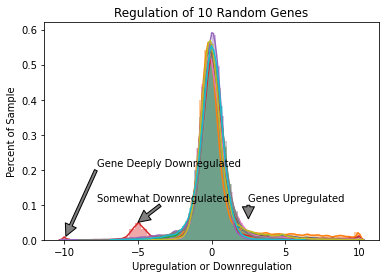

In [11]:
ax = sns.distplot(x_train['g-0'])
ax2 = sns.distplot(x_train['g-100'])
ax3 = sns.distplot(x_train['g-200'])
ax4 = sns.distplot(x_train['g-300'])
ax5 = sns.distplot(x_train['g-400'])
ax6 = sns.distplot(x_train['g-500'])
ax7 = sns.distplot(x_train['g-600'])
ax8 = sns.distplot(x_train['g-700'])
ax9 = sns.distplot(x_train['g-750'])
ax10 = sns.distplot(x_train['g-150'])

ax.set(title = "Regulation of 10 Random Genes",xlabel = "Upregulation or Downregulation",ylabel = "Percent of Sample");

plt.annotate("Gene Deeply Downregulated", xy = (-9.9, .01), xytext = (-7.8, 0.21),size = 10,arrowprops = {'facecolor':'grey', 'width':3})

plt.annotate("Somewhat Downregulated", xy = (-5, 0.05), xytext = (-7.8, 0.11), size = 10,
                arrowprops = {'facecolor':'grey', 'width':3})

plt.annotate("Genes Upregulated", xy = (2.5, 0.06), xytext = (2.5, 0.11), size = 10,
                arrowprops = {'facecolor':'grey', 'width':3})

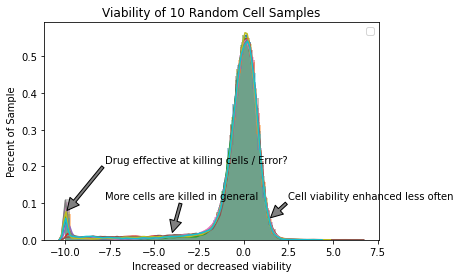

In [12]:
ax = sns.distplot(x_train['c-0'])
ax2 = sns.distplot(x_train['c-10'])
ax3 = sns.distplot(x_train['c-20'])
ax4 = sns.distplot(x_train['c-30'])
ax5 = sns.distplot(x_train['c-40'])
ax6 = sns.distplot(x_train['c-50'])
ax7 = sns.distplot(x_train['c-60'])
ax8 = sns.distplot(x_train['c-70'])
ax9 = sns.distplot(x_train['c-80'])
ax10 = sns.distplot(x_train['c-90'])

ax.set(title = "Viability of 10 Random Cell Samples",
          xlabel = "Increased or decreased viability",
          ylabel = "Percent of Sample")

plt.annotate("Drug effective at killing cells / Error?", xy = (-9.9, .08), xytext = (-7.8, 0.21),
                 size = 10,
                 arrowprops = {'facecolor':'grey', 'width':3})

plt.annotate("More cells are killed in general", xy = (-4, 0.02), xytext = (-7.8, 0.11), size = 10,
                arrowprops = {'facecolor':'grey', 'width':3})

plt.annotate("Cell viability enhanced less often", xy = (1.5, 0.06), xytext = (2.5, 0.11), size = 10,
                arrowprops = {'facecolor':'grey', 'width':3})

plt.legend()
plt.show()

***From this 2 graph we can see:***
1. That data is normalized from -10 to +10 ,and 
2. Explain about cell viability and genes regulation
3. There are outliers to in the dataset

In [13]:
out=[]
lis=['g-0']
def iqr_outliers(df):
    for i in df:
        q1 = df.quantile(0.25)
        q3 = df.quantile(0.75)
        iqr = q3-q1
        Lower_tail = q1 - 1.5 * iqr
        Upper_tail = q3 + 1.5 * iqr
        if i > Upper_tail or i < Lower_tail:
            out.append(i)
    print("Outliers:",out)

for i in lis:
    print(i,":",iqr_outliers(x_train[i]))
    


Outliers: [2.044, 8.738, 2.52, 4.746, 4.546, 2.2, 10.0, 2.891, 3.612, 2.119, 3.52, 2.93, 2.825, 2.849, 6.783, 6.812, 2.391, 3.005, 2.226, 5.154, -2.079, 4.355, 7.846, 3.864, 4.464, 2.948, 7.628, 8.499, -5.033, 4.315, 5.874, 4.242, 6.036, 5.62, 3.635, 3.849, 6.177, 2.082, 6.512, 2.459, 5.811, 2.887, 7.456, 8.157, 5.577, 3.937, 6.381, 3.021, 4.849, 7.421, -5.513, 4.567, 2.468, 2.145, -2.262, 2.283, 2.703, 2.137, 3.81, 2.909, 2.782, 3.126, 2.385, 4.29, 5.405, 2.891, 8.537, 5.477, 5.225, 7.154, 5.424, 9.97, 2.574, 2.543, -5.261, 3.6, 2.995, 2.543, 2.184, 2.871, 8.28, 5.147, 2.472, 5.215, 6.722, 3.055, 2.331, 2.999, 3.713, 3.343, 7.704, 7.411, -2.325, 2.912, 7.052, 3.766, 3.466, 4.549, 2.925, 3.354, 7.294, 2.42, 5.065, 7.035, 3.826, 7.379, 6.173, 3.002, 2.175, 3.316, 4.849, 2.431, 8.677, 5.354, 2.936, 4.216, 2.726, 2.87, 3.365, 3.783, 6.733, 2.791, 3.334, 2.28, 2.048, 2.766, 4.507, 2.307, 2.216, 2.184, 2.748, 2.045, 3.932, 2.805, -1.99, 5.387, 3.969, 6.619, 8.214, 3.873, -4.516, 4.592, 2.44

These are the outliers in the dataset

In [14]:
temp =x_train.groupby('cp_type').count()['sig_id'].reset_index().sort_values(by='sig_id',ascending=False)
temp.style.background_gradient(cmap='Reds')

For 'cp_type', the 'ctl_vehicle' refers to samples treated with a control perturbation.<br>
 For control perturbations, our targets are all zero, since they have no Mechanism of Action (MoA).

In [15]:
ctl_vehicle_idx = (x_train['cp_type'] == 'ctl_vehicle')
# evaluate number of 1s we have in the total train scores when cp_type = ctl_vehicle
y_train.loc[ctl_vehicle_idx].iloc[:, 1:].sum().sum()

0


1.   The total sum is zero, which confirms the statement above on all targets being zero for cases where cp_type is ctl_vehicle.


In [16]:
temp = x_train.groupby('cp_time').count()['sig_id'].reset_index().sort_values(by='sig_id',ascending=False)
temp.style.background_gradient(cmap='Blues')

So,we have monitored the drug at all the time 

In [17]:
temp = x_train.groupby('cp_dose').count()['sig_id'].reset_index().sort_values(by='sig_id',ascending=False)
temp.style.background_gradient(cmap='Greens')


From these 3 table we get to know:
1. Each drug was tested under two dose (cp_dose) and three times (cp_time). So, six samples basically correspond to one drug.
2. cp_type indicates samples treated with a compound (cp_vehicle) or with a control perturbation (ctrl_vehicle).So,More sampls are treated with cp_vehicle then ctrl_vehicle 
3. In this samples we have approximately same ids in different Doses and at different time.

Text(0.5, 1.0, 'Percentage of samples with MoA counts')

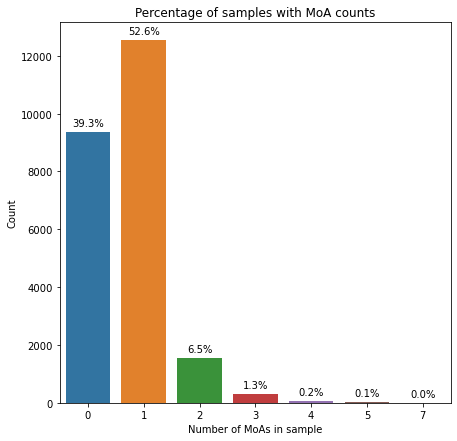

In [18]:
out = dict()

arr=y_train.drop('sig_id',axis=1).values==1
for a in range(len(arr)):
    o=np.sum(arr[a])
    if o not in out.keys():
        out[o]=1
    else:
        out[o]+=1

length = 23814
plt.figure(figsize=(7,7))
splot = sns.barplot(x=list(out.keys()),y=list(out.values()))
for p in splot.patches:
    splot.annotate(format(p.get_height()*100/length, '.1f')+'%', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.xlabel('Number of MoAs in sample')
plt.ylabel('Count')
plt.title('Percentage of samples with MoA counts')


Most of the sample have 1 MOA i.e drug act as one of the target type and its percentage is **52.6%**

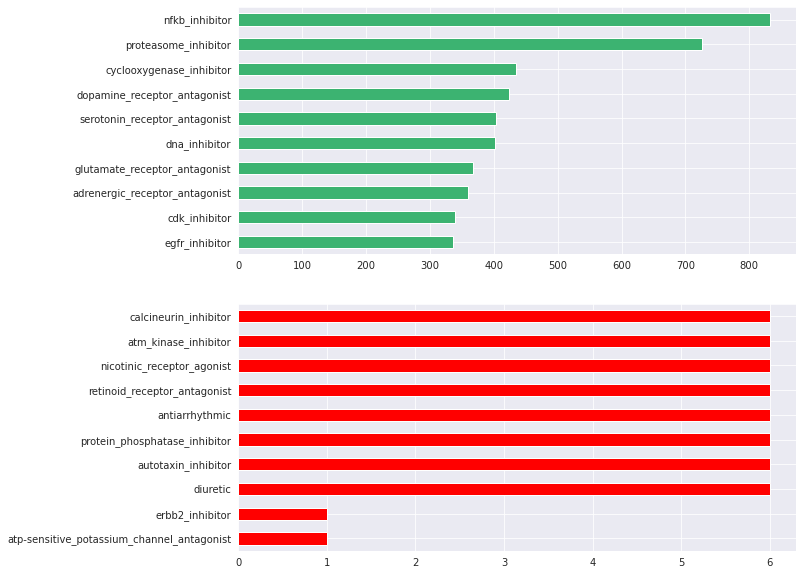

In [19]:
target_s_copy=y_train.copy()
target_s_copy.drop('sig_id', axis=1, inplace=True)

sns.set_style('darkgrid')
fig,ax = plt.subplots(2,1,figsize = (10,10))
target_s_copy.sum().sort_values()[-10:].plot(kind='barh',color='mediumseagreen',ax=ax[0])
target_s_copy.sum().sort_values()[:10].plot(kind='barh',color='red',ax=ax[1])

plt.show()

**The classes in the training set are highly imbalanced:**
1. nfkb_inhibitor represents the largest single class with 832 entries.
2. atp-sensitive_potassium_channel_antagonist and erbb2_inhibitor represent the smallest classes with only one entry each.

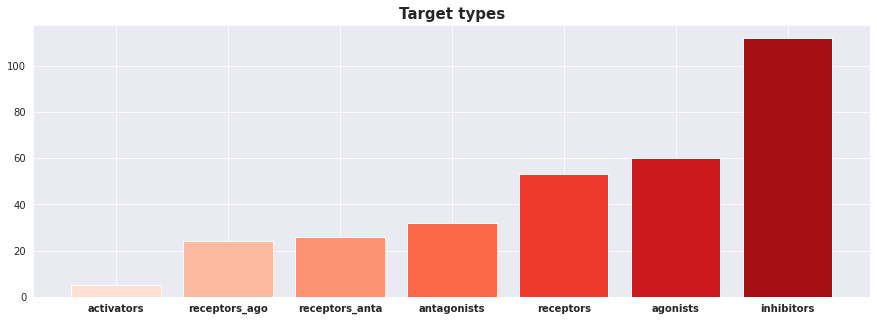

In [20]:
d=y_train
inhibitors = [col for col in d.columns if 'inhibitor' in col]
activators = [col for col in d.columns if 'activator' in col]
antagonists = [col for col in d.columns if 'antagonist' in col]
agonists = [col for col in d.columns if 'agonist' in col]
modulators = [col for col in d.columns if 'modulator' in col]
receptors = [col for col in d.columns if 'receptor' in col]
receptors_ago = [col for col in d.columns if 'receptor_agonist' in col]
receptors_anta = [col for col in d.columns if 'receptor_antagonist' in col]


labelss= {'Drugs': ['inhibitors', 'activators', 'antagonists', 'agonists', 'receptors', 'receptors_ago', 'receptors_anta'],
          'Count':[112,5,32,60, 53, 24, 26]}


labels= pd.DataFrame(labelss)
labels=labels.sort_values(by=['Count'])
plt.figure(figsize=(15,5))
plt.bar(labels['Drugs'], labels['Count'], color=sns.color_palette('Reds',len(labels)))
plt.xticks(weight='bold')
plt.title('Target types', weight='bold', fontsize=15)
plt.show()

Inhibitor targets are dominating with 121 targets (out of 206).

In [21]:
# drug file contains drug_id along with S.no so we are joining drug and x_train 
x_train=pd.merge(drug, x_train, how='inner', on='sig_id')

In [22]:
x_train.groupby('cp_type')['drug_id'].describe()

count unique        top  freq
cp_type                                   
ctl_vehicle   1866      1  cacb2b860  1866
trt_cp       21948   3288  87d714366   718

1. Now,as you know that we have only one drug in ctl_vehicle and many in trt_cp so we are randomly taking a drug from trt_Cp and one and only drug in ctl_vechicle then analysis them on basis of variour parameters
2. But 1 drug of cp_type have 1866 times occured
3. Now, analyasing drugs of these two type at different time and doses

Storing index for ctl_vechicle for futher use 

In [23]:
ctl_vehicle_idx = (x_test['cp_type'] == 'ctl_vehicle')
idx=x_test[ctl_vehicle_idx]['sig_id']

In [24]:
# sepreating gene columns
gene_cols = [col for col in x_train if col.startswith('g-')]
gene_cols.insert(0,'cp_time')
gene_cols.insert(1,'cp_dose')
# seperating cell columns
cell_cols = [col for col in x_train if col.startswith('c-')]
cell_cols.insert(0,'cp_time')
cell_cols.insert(1,'cp_dose')

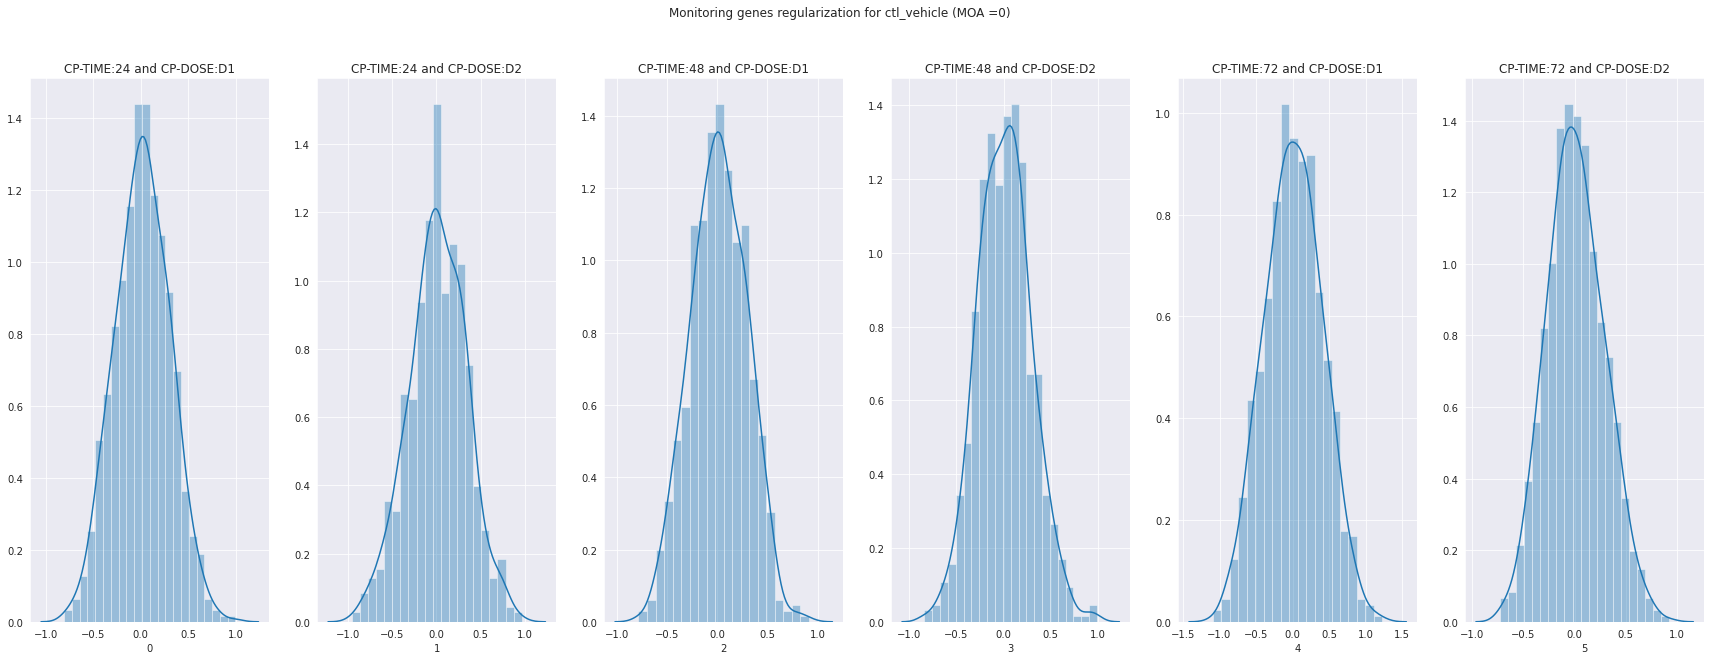

In [25]:
# ctl_vehicle
gene_ctl_vehicle=x_train[x_train['drug_id']=='cacb2b860'][gene_cols]
g=gene_ctl_vehicle.groupby(['cp_time','cp_dose']).mean()
g.reset_index()
g=g.reset_index()
g=g.T
import statsmodels.api as sm 
f,ax = plt.subplots(1,6,figsize=(30,10))
f.suptitle('Monitoring genes regularization for ctl_vehicle (MOA =0)')
for i in range(0,6):
  sns.distplot(g.iloc[2:,i],ax=ax[i])
  ax[i].set_title('CP-TIME:{} and CP-DOSE:{}'.format(g.iloc[0,i],g.iloc[1,i]))

1. In genes regularization for ctl_vechical i.e the cp_type who MOA is 0 there is no change in genes activity except at time: 24 at dose D2 and at time :72 at dose D1



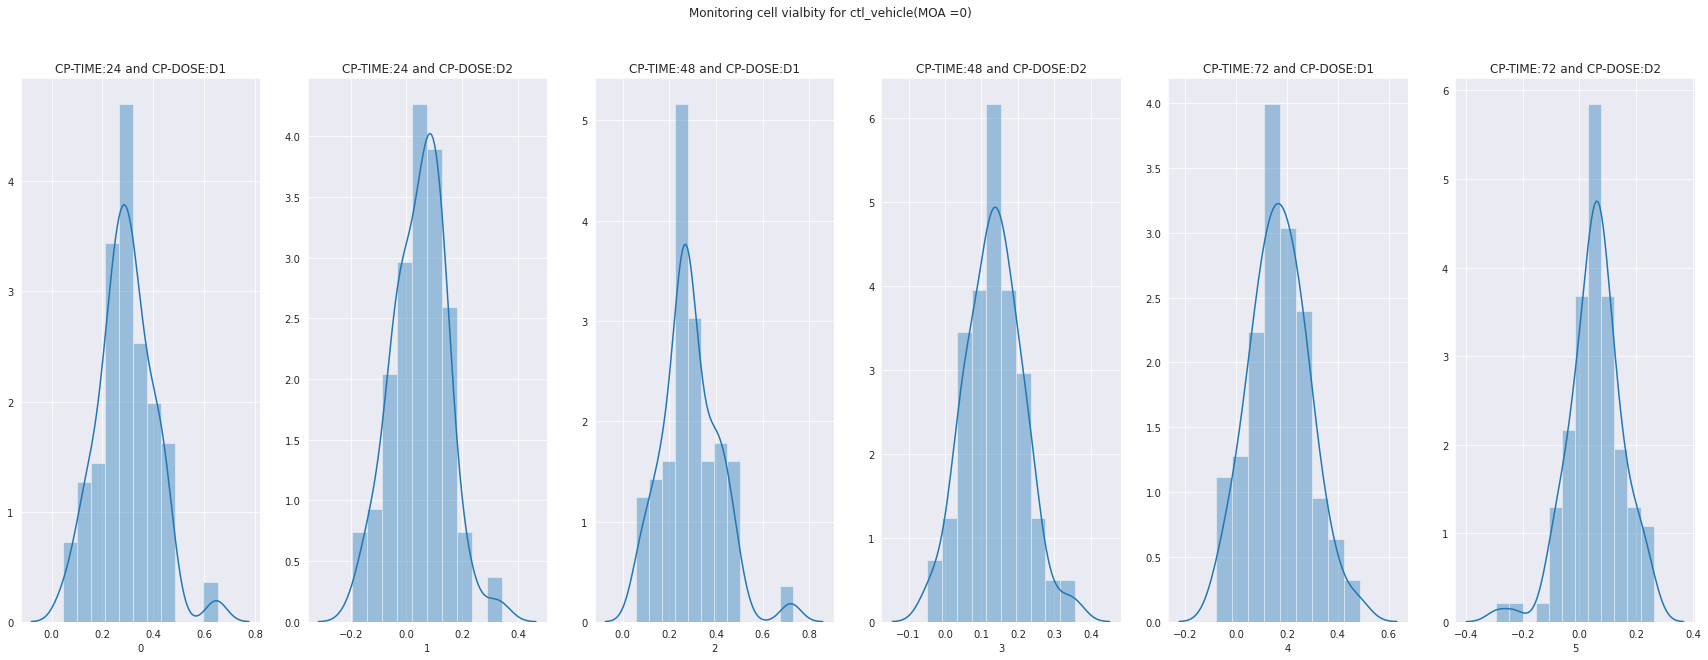

In [26]:
#ctl_vehicle
cell_ctl_vehicle=x_train[x_train['drug_id']=='cacb2b860'][cell_cols]
c=cell_ctl_vehicle.groupby(['cp_time','cp_dose']).mean()
c.reset_index()
c=c.reset_index()
c=c.T
import statsmodels.api as sm 
f,ax = plt.subplots(1,6,figsize=(30,10))
f.suptitle('Monitoring cell vialbity for ctl_vehicle(MOA =0)')
for i in range(0,6):
  sns.distplot(c.iloc[2:,i],ax=ax[i])
  ax[i].set_title('CP-TIME:{} and CP-DOSE:{}'.format(c.iloc[0,i],c.iloc[1,i]))

In cell vialbity for ctl_vechical i.e the cp_type who MOA is 0 there is change in cell activity at different time and doses

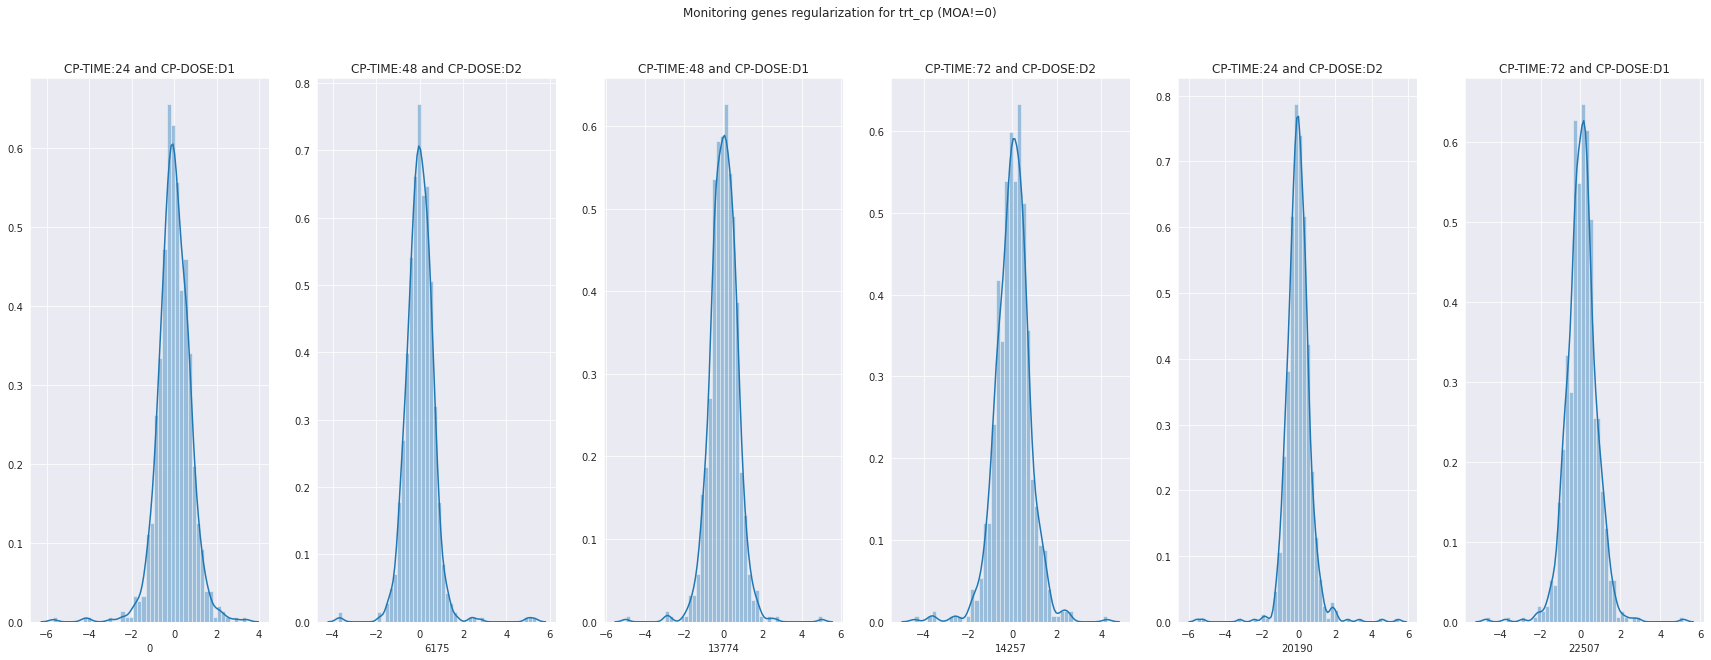

In [27]:
#trt_cp
trt_g=x_train[x_train['drug_id']=='b68db1d53'][gene_cols]
trt_g=trt_g.T
import statsmodels.api as sm 
f,ax = plt.subplots(1,6,figsize=(30,10))
f.suptitle('Monitoring genes regularization for trt_cp (MOA!=0)')

for i in range(0,6):
  sns.distplot(trt_g[trt_g.columns[i]][2:],ax=ax[i])
  ax[i].set_title('CP-TIME:{} and CP-DOSE:{}'.format(trt_g.iloc[0,i],trt_g.iloc[1,i]))

In genes regularization for trt_cp i.e the cp_type who MOA is not 0 there is no change in genes activity except at time: 24 at dose D2 

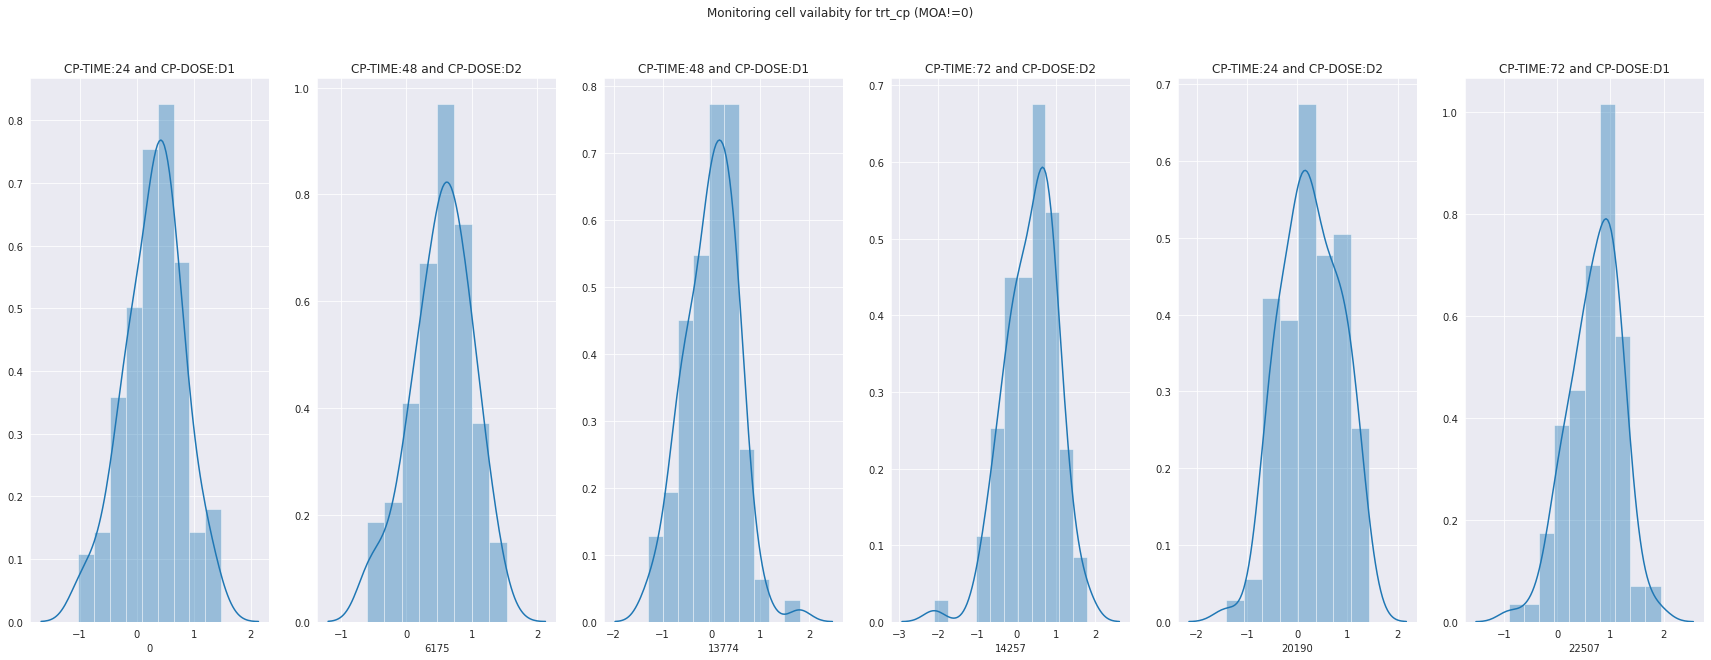

In [28]:
#trt_cp
trt_c=x_train[x_train['drug_id']=='b68db1d53'][cell_cols]
trt_c=trt_c.T
import statsmodels.api as sm 
f,ax = plt.subplots(1,6,figsize=(30,10))
f.suptitle('Monitoring cell vailabity for trt_cp (MOA!=0)')

for i in range(0,6):
  sns.distplot(trt_c[trt_c.columns[i]][2:],ax=ax[i])
  ax[i].set_title('CP-TIME:{} and CP-DOSE:{}'.format(trt_c.iloc[0,i],trt_c.iloc[1,i]))

In cell vialbity for trt_cp i.e the cp_type who MOA is not 0 there is change in cell activity at different time and doses

Inferences :
1. In genes regularization for ctl_vechical i.e the cp_type who MOA is 0 there is no change in genes activity except at time: 24 at dose D2 and at time :72 at dose D1
2. In cell vialbity for ctl_vechical i.e the cp_type who MOA is 0 there is change in cell activity at different time and doses
3. In genes regularization for trt_cp i.e the cp_type who MOA is not 0 there is no change in genes activity except at time: 24 at    dose D2 
4. In cell vialbity for trt_cp i.e the cp_type who MOA is not 0 there is change in cell activity at different time and doses

<h2>Inferential Statistics : Chi-square (χ2) test for independence</h2>
Chi-square test is a non-parametric method used to compare the relationship between the two categorical (nominal) variables in a contingency table.


---


1. Null hypotheses(H0): The two categorical variables are independent (no association between the two variables).
2. Alternative hypotheses(H1): The two categorical variables are dependent (there is an association between the two variables)


In [29]:
pd.crosstab(x_train['cp_type'],x_train['cp_dose'])

cp_dose         D1     D2
cp_type                  
ctl_vehicle    951    915
trt_cp       11196  10752

In [30]:
from scipy.stats import chi2_contingency,shapiro 
print('Chi square Test ')
print('H0: Variables are Independent')
print('H0: Variables are dependent \n')
data = pd.crosstab(x_train['cp_type'],x_train['cp_dose'])
stat, p, dof, expected = chi2_contingency(data) 
alpha = 0.05
print("p value:", p) 
if p <= alpha: 
    print('Conclusion: Variables are dependent(reject H0)') 
else: 
    print('Conclusion: Variables are Independent(H0 holds true)')

Chi square Test 
H0: Variables are Independent
H0: Variables are dependent 

p value: 0.9882330444376459
Conclusion: Variables are Independent(H0 holds true)


The P-value obtained from chi-square test for independence is not significant (P > 0.05), and therefore, we conclude that there is no significant association between variable.

  # CONCLUSION MADE FROM STATS AND EDA: 
  ---
  
  1. There is no null values in this dataset
  2. Our dataset is normalized between -10 to +10
  3. Distribution of test and train set are almost same so our ML algo will work good on test set 
  4. 772  gene features and 100 cell viabilty features
  5. There can be up and down regularization of genes and cells can also add or can be dead at different time of drugs and doses
  6. Inhibitor targets are dominating with 121 targets (out of 206).
  7. Most of the sample have 1 MOA i.e drug act as one of the target type and its percentage is 52.6%
  8. So, six samples basically correspond to one drug.
  9. So,More sampls are treated with trt_vehicle then ctrl_vehicle
  10. In this samples we have approximately same ids in different Doses and at different time.
  12. There is outliers in the dataset 
  13. There is Multiclass Imbalance problem 
  14. Cross-validation can be performed.
  

-------------------------------------------
--------------------------------------

# Feature Selection and Feature Cleaning

### Labelencoding

In [22]:
#label encoding
#x_train= pd.read_csv('/kaggle/input/lish-moa/train_features.csv')
from sklearn.preprocessing import LabelEncoder 
le = LabelEncoder() 
for i in range(0,2):
  x_train.iloc[:,i]= le.fit_transform(x_train.iloc[:,i]) 
  x_test.iloc[:,i]= le.fit_transform(x_test.iloc[:,i]) 
    



### Feature Selection

#### Constant feature removal

In [32]:
from sklearn.feature_selection import VarianceThreshold
constant_filter = VarianceThreshold(threshold=0)
constant_filter.fit(x_train)

VarianceThreshold(threshold=0.1)

Variance threshold from sklearn is a simple baseline approach to feature selection. It removes all features which variance doesn’t meet some threshold. By default, it removes all zero-variance features, i.e., features that have the same value in all samples.

In [33]:
# transform the x_train and x_test datasets into non constant datasets.
X_train_filter = constant_filter.transform(x_train)
X_test_filter = constant_filter.transform(x_test)

In [34]:
x_train.shape,X_train_filter.shape

((23814, 876), (23814, 875))

One feature has been removed .So,only one constant feature was there in the dataset

#### Quasi-constant features
Quasi-constant features are those that show the same value for the great majority of the observations of the dataset.

In [35]:
quasi_constant_filter= VarianceThreshold(threshold=0.2)  
quasi_constant_filter.fit(X_train_filter)

VarianceThreshold(threshold=0.1)

In [36]:
#To remove those quasi constant features, we need to apply transform on quasi transform filter object.
X_train_quasi_filter = quasi_constant_filter.transform(X_train_filter)
X_test_quasi_filter = quasi_constant_filter.transform(X_test_filter)

In [37]:
X_train_filter.shape,X_train_quasi_filter.shape

((23814, 875), (23814, 875))

No feature is removed

#### Remove Duplicate Features

In [38]:
X_train_T = X_train_quasi_filter.T
X_test_T = X_test_quasi_filter.T
X_train_T = pd.DataFrame(X_train_T)
X_test_T = pd.DataFrame(X_test_T)
X_train_T.duplicated().sum()

0

No duplicate features
#### Anova test

In [39]:
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest

labels=y_train.columns
selected_features = [] 

for label in labels:
    selection = SelectKBest(f_classif, k=10)
    fit=selection.fit(x_train, y_train[label])
    selected_features.append(list(fit.scores_))
x_train.columns[fit.get_support()]

Index(['g-142', 'g-252', 'g-390', 'g-486', 'g-516', 'g-700', 'c-9', 'c-50',
       'c-76', 'c-98'],
      dtype='object')

#### Mutual information

In [40]:
from sklearn.feature_selection import mutual_info_classif
labels=y_train.columns
mutual_info= [] 

for label in labels:
    sel_mutual= SelectKBest(mutual_info_classif, k=10)
    mutual=selection.fit(x_train, y_train[label])
    mutual_info.append(list(fit.scores_))
x_train.columns[mutual.get_support()]

Index(['g-142', 'g-252', 'g-390', 'g-486', 'g-516', 'g-700', 'c-9', 'c-50',
       'c-76', 'c-98'],
      dtype='object')

#### Correlated Feature Removal

In [25]:
def get_correlation(data, threshold):
    corr_col = set()
    corrmat = data.corr()
    for i in range(len(corrmat.columns)):
        for j in range(i):
            if abs(corrmat.iloc[i, j])> threshold:
                colname = corrmat.columns[i]
                corr_col.add(colname)
    return corr_col

corr_features = get_correlation(x_train, 0.85)


In [26]:
X_train_uncorr = x_train.drop(labels=corr_features,axis='columns')
X_test_uncorr = x_test.drop(labels = corr_features,axis='columns')
X_train_uncorr.shape, X_test_uncorr.shape

((21948, 788), (3677, 788))

In [27]:
print(876-788,'columns have been removed')

88 columns have been removed


# Dimensionalaty Reduction:PCA

In [28]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
principalComponents = pca.fit_transform(X_train_uncorr.fillna(0))
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PCA-1','PCA-2','PCA-3','PCA-4','PCA-5','PCA-6','PCA-7','PCA-8','PCA-9','PCA-10','PCA-11','PCA-12','PCA-13','PCA-14','PCA-15','PCA-16','PCA-17','PCA-18','PCA-19','PCA-20'])

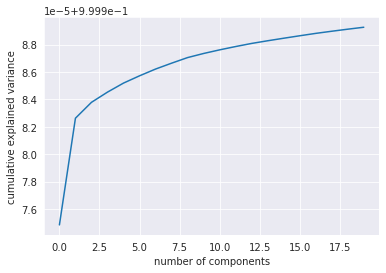

In [45]:
import matplotlib.pyplot as plt

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [29]:
print(pca.explained_variance_ratio_.round(2))


pca = PCA(n_components=25)
principalComponents = pca.fit_transform(X_train_uncorr)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PCA-1','PCA-2','PCA-3','PCA-4','PCA-5','PCA-6','PCA-7','PCA-8','PCA-9','PCA-10','PCA-11','PCA-12','PCA-13','PCA-14',
                           'PCA-15','PCA-16','PCA-17','PCA-18','PCA-19','PCA-20','PCA-21','PCA-22','PCA-23','PCA-24','PCA-25'])

[0.32 0.05 0.03 0.02 0.02 0.02 0.02 0.02 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.  ]


In [47]:
principalComponents = pca.transform(X_test_uncorr)
principalDf_test = pd.DataFrame(data = principalComponents
             , columns = ['PCA-1','PCA-2','PCA-3','PCA-4','PCA-5','PCA-6','PCA-7','PCA-8','PCA-9','PCA-10','PCA-11','PCA-12','PCA-13','PCA-14',
                           'PCA-15','PCA-16','PCA-17','PCA-18','PCA-19','PCA-20','PCA-21','PCA-22','PCA-23','PCA-24','PCA-25'])

# CLASSIFICATION-XGBOOST

In [48]:
from xgboost import XGBClassifier
from category_encoders import CountEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss
from sklearn.multioutput import MultiOutputClassifier

In [49]:
def metric(y_true, y_pred):
    metrics = []
    metrics.append(log_loss(y_true, y_pred.astype(float), labels=[0,1]))
    return np.mean(metrics)

In [61]:
y_train=y_train.drop('sig_id',axis='columns')
cols = y_train.columns
from sklearn.model_selection import KFold
N_SPLITS = 5
oof_loss = 0

for c, column in enumerate(cols,1):
    y = y_train[column]
    total_loss = 0
    
    for fn, (trn_idx, val_idx) in enumerate(KFold(n_splits = N_SPLITS, shuffle = True).split(principalDf)):
        print('Fold: ', fn+1)
        X_train, X_val = principalDf.iloc[trn_idx], principalDf.iloc[val_idx]
        Y_train, y_val = y.loc[trn_idx], y.loc[val_idx]
        
        model = XGBClassifier(tree_method = 'gpu_hist',
                         min_child_weight = 31.58,
                         learning_rate = 0.05,
                         colsample_bytree = 0.65,
                         gamma = 3.69,
                         max_delta_step = 2.07,
                         max_depth = 10,
                         n_estimators = 166,
                         subsample = 0.86)
    
        model.fit(X_train, Y_train)
        pred = model.predict(X_val)
     
        loss = metric(y_val,pred)
        total_loss += loss
    oof_loss += total_loss/N_SPLITS
    print("Model "+str(c)+": Loss ="+str(total_loss/N_SPLITS))

Fold:  1
Fold:  2
Fold:  3
Fold:  4
Fold:  5
Model 1: Loss =0.024655320248225414
Fold:  1
Fold:  2
Fold:  3
Fold:  4
Fold:  5
Model 2: Loss =0.026107138068289477
Fold:  1
Fold:  2
Fold:  3
Fold:  4
Fold:  5
Model 3: Loss =0.03480890831265076
Fold:  1
Fold:  2
Fold:  3
Fold:  4
Fold:  5
Model 4: Loss =0.2755642807465292
Fold:  1
Fold:  2
Fold:  3
Fold:  4
Fold:  5
Model 5: Loss =0.436556776054971
Fold:  1
Fold:  2
Fold:  3
Fold:  4
Fold:  5
Model 6: Loss =0.10587671542280974
Fold:  1
Fold:  2
Fold:  3
Fold:  4
Fold:  5
Model 7: Loss =0.07832080509313155
Fold:  1
Fold:  2
Fold:  3
Fold:  4
Fold:  5
Model 8: Loss =0.139233501359528
Fold:  1
Fold:  2
Fold:  3
Fold:  4
Fold:  5
Model 9: Loss =0.017404454156325883
Fold:  1
Fold:  2
Fold:  3
Fold:  4
Fold:  5
Model 10: Loss =0.3915964115689679
Fold:  1
Fold:  2
Fold:  3
Fold:  4
Fold:  5
Model 11: Loss =0.5221275335723987
Fold:  1
Fold:  2
Fold:  3
Fold:  4
Fold:  5
Model 12: Loss =0.09572434558185414
Fold:  1
Fold:  2
Fold:  3
Fold:  4
Fold:

Fold:  4
Fold:  5
Model 102: Loss =0.08702166166989053
Fold:  1
Fold:  2
Fold:  3
Fold:  4
Fold:  5
Model 103: Loss =0.10442489760274568
Fold:  1
Fold:  2
Fold:  3
Fold:  4
Fold:  5
Model 104: Loss =0.14938861220329053
Fold:  1
Fold:  2
Fold:  3
Fold:  4
Fold:  5
Model 105: Loss =0.08557167118503109
Fold:  1
Fold:  2
Fold:  3
Fold:  4
Fold:  5
Model 106: Loss =0.34953937816722547
Fold:  1
Fold:  2
Fold:  3
Fold:  4
Fold:  5
Model 107: Loss =0.034808908312650766
Fold:  1
Fold:  2
Fold:  3
Fold:  4
Fold:  5
Model 108: Loss =0.04641248686193554
Fold:  1
Fold:  2
Fold:  3
Fold:  4
Fold:  5
Model 109: Loss =0.10442398393514338
Fold:  1
Fold:  2
Fold:  3
Fold:  4
Fold:  5
Model 110: Loss =0.3669400026577744
Fold:  1
Fold:  2
Fold:  3
Fold:  4
Fold:  5
Model 111: Loss =0.10007583981576965
Fold:  1
Fold:  2
Fold:  3
Fold:  4
Fold:  5
Model 112: Loss =0.05366213473036535
Fold:  1
Fold:  2
Fold:  3
Fold:  4
Fold:  5
Model 113: Loss =0.04351037400114461
Fold:  1
Fold:  2
Fold:  3
Fold:  4
Fold:  

Fold:  3
Fold:  4
Fold:  5
Model 202: Loss =0.008702074800229723
Fold:  1
Fold:  2
Fold:  3
Fold:  4
Fold:  5
Model 203: Loss =0.24656081637893107
Fold:  1
Fold:  2
Fold:  3
Fold:  4
Fold:  5
Model 204: Loss =0.03770949839410452
Fold:  1
Fold:  2
Fold:  3
Fold:  4
Fold:  5
Model 205: Loss =0.05656363847942142
Fold:  1
Fold:  2
Fold:  3
Fold:  4
Fold:  5
Model 206: Loss =0.043510069445277175


# Clusterning

In [ ]:
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN

In [ ]:
gene_expression=x_train.loc[:,x_train.columns.str.contains('g-')]

In [ ]:
k=9
k_means=KMeans(n_clusters=k,random_state=42)
clust=k_means.fit_transform(gene_expression)

In [ ]:
train_feat_cluster=x_train.copy()
train_feat_cluster['cluster']=k_means.labels_

In [ ]:
train_feat_cluster['cluster'].value_counts()

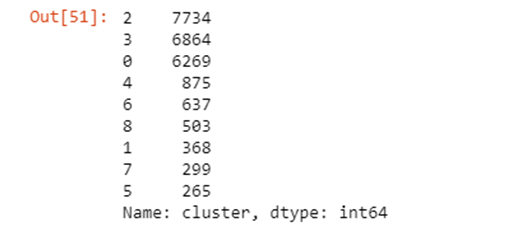

In [ ]:
## Visualizing the clusters:
tsne=TSNE(n_components=2,verbose=1,perplexity=100,random_state=42)
train_feat_embedded=tsne.fit_transform(gene_expression.values)

In [ ]:
plt.figure(figsize=(10,10))
palette=sns.hls_palette(9,l=0.5,s=0.6)
sns.scatterplot(train_feat_embedded[:,0],train_feat_embedded[:,1],hue=train_feat_cluster['cluster'],palette=palette)
plt.title("t-SNE with cluster",fontsize=10)
plt.xlabel('x',fontsize=8)
plt.ylabel('y',fontsize=8)



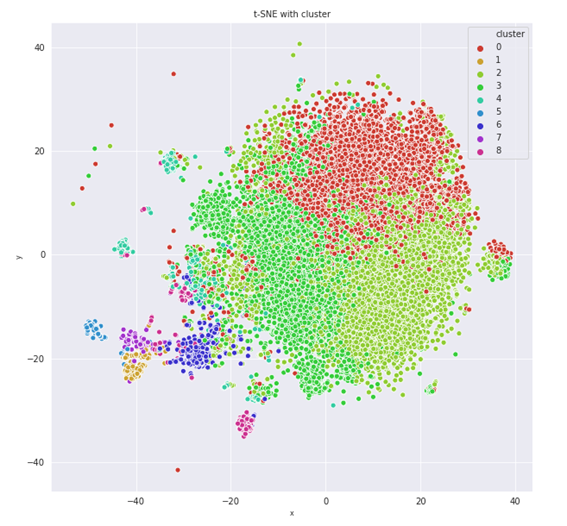

Here are my interpretations,
* There is a non-linear separation boundary between each clusters.K-means and t-SNE seem to agree on the points used for separation though there are a few points where the clusters are different.
* Cluster 2 & 3 form a large portion of the gene expression data.

# Deep Learning
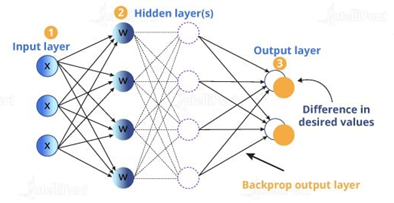



In [68]:
from tensorflow.keras import Input, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout

In [69]:
# number of layer is called depth
def model():
    INPUT_SHAPE = principalDf.shape[1]# 25
    OUTPUT_SHAPE = y_train.shape[1] #206
    input_tensor = Input(shape = (INPUT_SHAPE, ))
    layer = Dense(SIZE_LAYER, activation = 'relu')(input_tensor)
    layer = BatchNormalization(input_shape = (INPUT_SHAPE, ))(layer)
    layer = Dropout(0.2)(layer)
    layer=  Dense(4096, activation="relu")(layer)
    layer = BatchNormalization(input_shape = (INPUT_SHAPE, ))(layer)
    layer = Dropout(0.2)(layer)
    layer=  Dense(4096, activation="relu")(layer)
    layer = BatchNormalization(input_shape = (INPUT_SHAPE, ))(layer)
    layer = Dropout(0.2)(layer)
    layer = BatchNormalization(input_shape = (INPUT_SHAPE, ))(layer)
    layer=  Dense(4096, activation="relu")(layer)
    layer = Dropout(0.2)(layer)
    output_tensor = Dense(OUTPUT_SHAPE, activation = 'softmax')(layer)
    model = Model(input_tensor, output_tensor)
    model.compile(optimizer = tf.keras.optimizers.Adam(lr=2.75e-5),
                     loss = 'binary_crossentropy',
                     metrics = ['acc'])
    return model

In [71]:
import tensorflow as tf
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import ReduceLROnPlateau
NFOLD = 5
kf =KFold(n_splits=NFOLD)
#y_train=y_train.drop('sig_id',axis='columns')

BATCH_SIZE=128
EPOCHS=300
cnt=0
pe = np.zeros((x_test.shape[0], 206))
for tr_idx, val_idx in kf.split(principalDf):
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, epsilon=1e-4, mode='min')
    
    cnt += 1
    print(f"FOLD {cnt}")
    net = model()
    X_train, X_val = principalDf.iloc[tr_idx], principalDf.iloc[val_idx]
    y_trai, y_vald =y_train.loc[tr_idx], y_train.loc[val_idx]
    
    net.fit(X_train, y_trai, batch_size=BATCH_SIZE, epochs=EPOCHS, 
            validation_data=(X_val, y_vald), verbose=0, callbacks=[reduce_lr_loss])
    
    print("train", net.evaluate(X_train,y_trai, verbose=0, batch_size=BATCH_SIZE))
    print("val", net.evaluate(X_val, y_vald, verbose=0, batch_size=BATCH_SIZE))
    pe += net.predict(principalDf_test, batch_size=BATCH_SIZE, verbose=0) / NFOLD

FOLD 1

Epoch 00013: ReduceLROnPlateau reducing learning rate to 2.750000021478627e-06.

Epoch 00022: ReduceLROnPlateau reducing learning rate to 2.750000021478627e-07.

Epoch 00028: ReduceLROnPlateau reducing learning rate to 2.7499999077917894e-08.

Epoch 00031: ReduceLROnPlateau reducing learning rate to 2.7499998722646525e-09.

Epoch 00034: ReduceLROnPlateau reducing learning rate to 2.7499997834468105e-10.

Epoch 00037: ReduceLROnPlateau reducing learning rate to 2.749999672424508e-11.

Epoch 00040: ReduceLROnPlateau reducing learning rate to 2.7499997071189777e-12.

Epoch 00043: ReduceLROnPlateau reducing learning rate to 2.7499996637508906e-13.

Epoch 00046: ReduceLROnPlateau reducing learning rate to 2.7499996637508907e-14.

Epoch 00049: ReduceLROnPlateau reducing learning rate to 2.7499996976322085e-15.

Epoch 00052: ReduceLROnPlateau reducing learning rate to 2.749999612928914e-16.

Epoch 00055: ReduceLROnPlateau reducing learning rate to 2.749999665868473e-17.

Epoch 00058: 


Epoch 00076: ReduceLROnPlateau reducing learning rate to 2.7499997107817955e-22.

Epoch 00079: ReduceLROnPlateau reducing learning rate to 2.7499996602946975e-23.

Epoch 00082: ReduceLROnPlateau reducing learning rate to 2.74999972340357e-24.

Epoch 00085: ReduceLROnPlateau reducing learning rate to 2.7499996839605245e-25.

Epoch 00088: ReduceLROnPlateau reducing learning rate to 2.749999683960525e-26.

Epoch 00091: ReduceLROnPlateau reducing learning rate to 2.7499996223307663e-27.

Epoch 00094: ReduceLROnPlateau reducing learning rate to 2.7499995452935687e-28.

Epoch 00097: ReduceLROnPlateau reducing learning rate to 2.74999949714532e-29.

Epoch 00100: ReduceLROnPlateau reducing learning rate to 2.749999557330631e-30.

Epoch 00103: ReduceLROnPlateau reducing learning rate to 2.7499996325622693e-31.

Epoch 00106: ReduceLROnPlateau reducing learning rate to 2.749999679582043e-32.

Epoch 00109: ReduceLROnPlateau reducing learning rate to 2.7499996795820432e-33.

Epoch 00112: ReduceLRO


Epoch 00119: ReduceLROnPlateau reducing learning rate to 2.749999583154772e-38.

Epoch 00122: ReduceLROnPlateau reducing learning rate to 2.7499994710508953e-39.

Epoch 00125: ReduceLROnPlateau reducing learning rate to 2.749999190791202e-40.

Epoch 00128: ReduceLROnPlateau reducing learning rate to 2.749992184298881e-41.

Epoch 00131: ReduceLROnPlateau reducing learning rate to 2.7500482362374535e-42.

Epoch 00134: ReduceLROnPlateau reducing learning rate to 2.7493475870052913e-43.

Epoch 00137: ReduceLROnPlateau reducing learning rate to 2.7465449900766417e-44.

Epoch 00140: ReduceLROnPlateau reducing learning rate to 2.802596928649634e-45.

Epoch 00143: ReduceLROnPlateau reducing learning rate to 2.8025969286496343e-46.
train [0.016628103330731392, 0.10250892490148544]
val [0.019650325179100037, 0.07643847167491913]


In [ ]:

columns = pd.read_csv('../input/lish-moa/train_targets_scored.csv')
del columns['sig_id']
sub = pd.DataFrame(data=pe, columns=columns.columns)
sample = pd.read_csv('../input/lish-moa/sample_submission.csv')
sub.insert(0, column = 'sig_id', value=sample['sig_id'])

Here making the prediction 0 for clt-vechical as this moa is 0

In [ ]:
for i in idx:
    sub[sub['sig_id']==i].iloc[:,1:]=0

# Result:
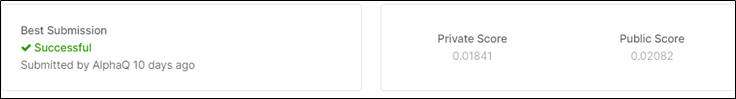

# Thank you